In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
# import dask.dataframe as dd


In [2]:
# from dask.distributed import Client
# client = Client(memory_limit='10GB')  # Tăng giới hạn bộ nhớ
# # client.close()


In [3]:
save_dir="../../exps"

In [4]:
df = pd.read_csv(f'{save_dir}/train_lag1_days_pre_processing.csv', index_col=None)

# df = dd.read_csv(f'{save_dir}/train_lag1_pre_processing.csv')
# df = df.compute() 
has_null = df.isnull().values.any()
print("DataFrame có chứa giá trị NaN không?", has_null)

len(df)

DataFrame có chứa giá trị NaN không? True


68846

In [5]:
df

,Unnamed: 0,county,is_business,product_type,is_consumption,prediction_unit_id,date,data_block_id,data_block_id_right,origin_date,...,surface_pressure_hl_7d,cloudcover_total_hl_7d,cloudcover_low_hl_7d,cloudcover_mid_hl_7d,cloudcover_high_hl_7d,windspeed_10m_hl_7d,winddirection_10m_hl_7d,shortwave_radiation_hl_7d,direct_solar_radiation_hl_7d,diffuse_radiation_hl_7d
0,0,0,0,1,0,0,2022-01-01,122.0,122.0,2021-12-30,...,-1.098545,0.364756,0.540221,-0.102747,-0.219846,0.145623,0.765906,-1.098287,-0.907099,-1.263447
1,516,0,0,1,1,0,2022-01-01,122.0,122.0,2021-12-30,...,-1.098545,0.364756,0.540221,-0.102747,-0.219846,0.145623,0.765906,-1.098287,-0.907099,-1.263447
2,1032,0,0,2,0,1,2022-01-01,122.0,122.0,2021-12-30,...,-1.098545,0.364756,0.540221,-0.102747,-0.219846,0.145623,0.765906,-1.098287,-0.907099,-1.263447
3,1548,0,0,2,1,1,2022-01-01,122.0,122.0,2021-12-30,...,-1.098545,0.364756,0.540221,-0.102747,-0.219846,0.145623,0.765906,-1.098287,-0.907099,-1.263447
4,2064,0,0,3,0,2,2022-01-01,122.0,122.0,2021-12-30,...,-1.098545,0.364756,0.540221,-0.102747,-0.219846,0.145623,0.765906,-1.098287,-0.907099,-1.263447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68841,66781,15,1,0,1,64,2023-05-31,637.0,637.0,2023-05-29,...,-0.192621,-0.064801,-1.187006,1.462371,-0.214599,-1.127396,0.696150,0.231730,-0.055061,0.876067
68842,67297,15,1,1,0,59,2023-05-31,637.0,637.0,2023-05-29,...,-0.192621,-0.064801,-1.187006,1.462371,-0.214599,-1.127396,0.696150,0.231730,-0.055061,0.876067
68843,67813,15,1,1,1,59,2023-05-31,637.0,637.0,2023-05-29,...,-0.192621,-0.064801,-1.187006,1.462371,-0.214599,-1.127396,0.696150,0.231730,-0.055061,0.876067
68844,68329,15,1,3,0,60,2023-05-31,637.0,637.0,2023-05-29,...,-0.192621,-0.064801,-1.187006,1.462371,-0.214599,-1.127396,0.696150,0.231730,-0.055061,0.876067


In [6]:
df=df.drop(columns=['Unnamed: 0','date','origin_date','origin_date_right'])
# df.isnull().sum()
df.dropna(inplace=True)
len(df)

67714

In [7]:
for i in df.columns:
    print(i,end=',')

county,is_business,product_type,is_consumption,prediction_unit_id,data_block_id,data_block_id_right,segment,sin(dayofyear),cos(dayofyear),target,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity,euros_per_mwh,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation,hours_ahead_fl,temperature_fl,dewpoint_fl,cloudcover_high_fl,cloudcover_low_fl,cloudcover_mid_fl,cloudcover_total_fl,10_metre_u_wind_component_fl,10_metre_v_wind_component_fl,direct_solar_radiation_fl,surface_solar_radiation_downwards_fl,snowfall_fl,total_precipitation_fl,hours_ahead_fd_7d,temperature_fd_7d,dewpoint_fd_7d,cloudcover_high_fd_7d,cloudcover_low_fd_7d,cloudcover_mid_fd_7d,cloudcover_total_fd_7d,10_metre_u_wind_component_fd_7d,10_metre_v_wind_component_fd_7d,direct_solar_radiation_fd_7d,surface_solar_radiation_downwards_fd_7d,sno

In [8]:
X = df.drop('target', axis=1)
y = df['target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

In [ ]:
X.to_csv(f'{save_dir}/X_train_lag1_days_pre_processing.csv')
y.to_csv(f'{save_dir}/y_train_lag1_days_pre_processing.csv')
X_train.to_csv(f'{save_dir}/X_train_train_lag1_days_pre_processing.csv')
X_test.to_csv(f'{save_dir}/X_test_train_lag1_days_pre_processing.csv')
y_train.to_csv(f'{save_dir}/y_train_train_lag1_days_pre_processing.csv')
y_test.to_csv(f'{save_dir}/y_test_train_lag1_days_pre_processing.csv')

Evaluating LR...
neg_mean_absolute_error LR: -0.355 (0.015)
r2 LR: 0.526 (0.044)
Evaluating Ridge...
neg_mean_absolute_error Ridge: -0.355 (0.015)
r2 Ridge: 0.527 (0.044)
Evaluating Lasso...
neg_mean_absolute_error Lasso: -0.307 (0.019)
r2 Lasso: 0.452 (0.028)
Evaluating DT...
neg_mean_absolute_error DT: -0.067 (0.006)
r2 DT: 0.951 (0.007)
Evaluating RF...
neg_mean_absolute_error RF: -0.052 (0.004)
r2 RF: 0.972 (0.003)
Evaluating GBR...
neg_mean_absolute_error GBR: -0.278 (0.011)
r2 GBR: 0.783 (0.033)
Evaluating LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17920
[LightGBM] [Info] Number of data points in the train set: 20111, number of used features: 93
[LightGBM] [Info] Start training from score 0.053774
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

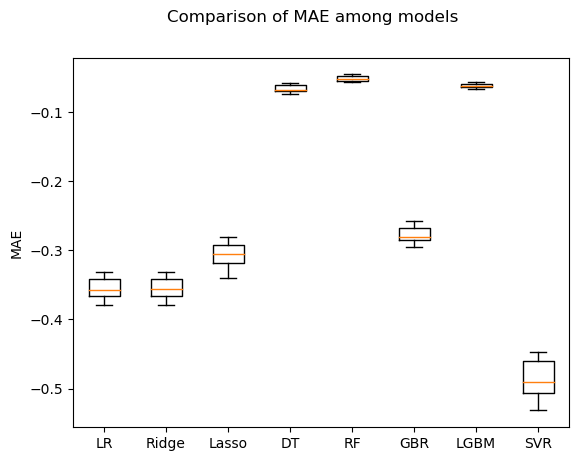

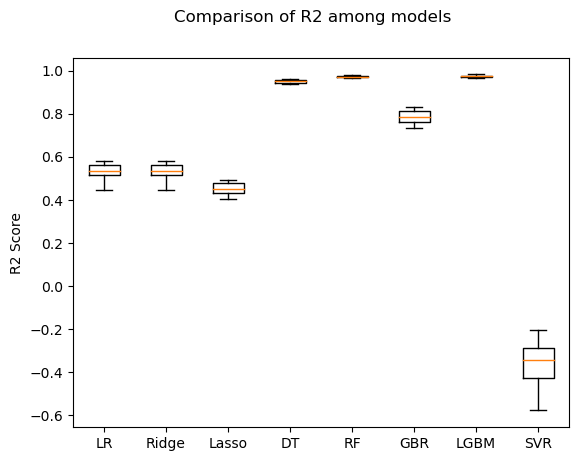

In [10]:


num_folds = 10
seed = 7
scorers = {'mae': make_scorer(mean_absolute_error), 'r2': make_scorer(r2_score)}
models = []

# Defining models
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge(alpha=1.0)))
models.append(('Lasso', Lasso(alpha=0.1)))
models.append(('DT', DecisionTreeRegressor(random_state=42)))
models.append(('RF', RandomForestRegressor(n_estimators=100, random_state=42)))
models.append(('GBR', GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)))
models.append(('LGBM', lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=100, verbose=-1)))
models.append(('SVR', SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)))

# Function to evaluate models
def check_model(name, model, X, y, scoring):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    msg = f"{scoring} {name}: {cv_results.mean():.3f} ({cv_results.std():.3f})"
    print(msg)
    return cv_results

results_mae = []
names_mae = []
results_r2 = []
names_r2 = []

# Evaluating models
for name, model in models:
    print(f"Evaluating {name}...")
    mae_result = check_model(name, model, X_test, y_test, scoring='neg_mean_absolute_error')
    results_mae.append(mae_result)
    names_mae.append(name)
    
    r2_result = check_model(name, model, X_test, y_test, scoring='r2')
    results_r2.append(r2_result)
    names_r2.append(name)

# Plotting MAE
fig_mae = plt.figure()
fig_mae.suptitle('Comparison of MAE among models')
ax_mae = fig_mae.add_subplot(111)
plt.boxplot(results_mae)
ax_mae.set_xticklabels(names_mae)
plt.ylabel('MAE')
plt.show()

# Plotting R2
fig_r2 = plt.figure()
fig_r2.suptitle('Comparison of R2 among models')
ax_r2 = fig_r2.add_subplot(111)
plt.boxplot(results_r2)
ax_r2.set_xticklabels(names_r2)
plt.ylabel('R2 Score')
plt.show()


In [11]:
# Train Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)



DecisionTreeRegressor(random_state=42)

In [12]:
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [13]:
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

# Visualize Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

Feature ranking:
1. feature installed_capacity (0.4759749267317165)
2. feature segment (0.39313792318944907)
3. feature surface_solar_radiation_downwards_fl (0.030377466761012994)
4. feature is_consumption (0.022448704713295475)
5. feature is_business (0.017346809035774603)
6. feature county (0.008075363308671262)
7. feature eic_count (0.00404481532739263)
8. feature data_block_id_right (0.00367846876141818)
9. feature surface_solar_radiation_downwards (0.0034739537801348414)
10. feature cos(dayofyear) (0.0033949474079892324)
11. feature direct_solar_radiation_hd_7d (0.002771653042054449)
12. feature direct_solar_radiation (0.002040204839234837)
13. feature product_type (0.001199478772435862)
14. feature direct_solar_radiation_fl (0.0011689780522056896)
15. feature cloudcover_high_fl_7d (0.0010781083594623405)
16. feature euros_per_mwh (0.0009700081948090941)
17. feature lowest_price_per_mwh (0.0009281041944240994)
18. feature winddirection_10m (0.0008947875717696379)
19. feature tempe

NameError: name 'plot_tree' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# Train LightGBM model
lgbm_model = lgb.LGBMRegressor(objective='regression', num_leaves=31, learning_rate=0.1, n_estimators=100)
lgbm_model.fit(X_train, y_train)

In [ ]:
# Evaluating SHAP for Decision Tree
explainer_dt = shap.Explainer(dt_model, X_train)
shap_values_dt = explainer_dt(X_test)

# Evaluating SHAP for LightGBM
explainer_lgbm = shap.Explainer(lgbm_model, X_train)
shap_values_lgbm = explainer_lgbm(X_test)

# Evaluating LIME for Decision Tree
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, verbose=True, mode='regression')
lime_exp_dt = lime_explainer.explain_instance(X_test.iloc[0].values, dt_model.predict)

# Evaluating LIME for LightGBM
lime_exp_lgbm = lime_explainer.explain_instance(X_test.iloc[0].values, lgbm_model.predict)

In [ ]:


# SHAP summary plot for Decision Tree
shap.summary_plot(shap_values_dt, X_test, plot_type="bar", title="SHAP Decision Tree Feature Importance")

# SHAP summary plot for LightGBM
shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar", title="SHAP LightGBM Feature Importance")

# LIME explanation for Decision Tree
lime_exp_dt.show_in_notebook()

# LIME explanation for LightGBM
lime_exp_lgbm.show_in_notebook()


# Detailed force plot for one sample in the test set
shap.force_plot(explainer_dt.expected_value, shap_values_dt[0,:], X_test.iloc[0,:], matplotlib=True)
shap.force_plot(explainer_lgbm.expected_value, shap_values_lgbm[0,:], X_test.iloc[0,:], matplotlib=True)